In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

data = h5py.File('../samples.h5', 'r')
print(len(data.keys()))

51


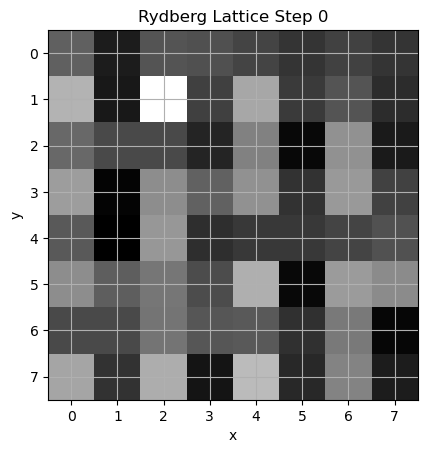

In [2]:
every = 100
for step in range(len(data.keys()))[::every]:
    # Average over the batch dimension and reshape to square lattice
    samples_avg = np.mean(np.array(data[f"step_{step:05d}"]), axis=0).reshape(8, 8)
    
    # Plot the average lattice
    plt.imshow(samples_avg, cmap='gray')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Rydberg Lattice Step {step}")
    plt.grid()
    plt.show()